# Stabilité du modèle sur 12 mois

## Importation des librairies

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
import pickle
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow_hub as hub
import tensorflow as tf
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_score, f1_score

# mlflow
import os
import mlflow

# Plot
import matplotlib.pyplot as plt

# Pour améliorer les performances (parallélisme)
import mapply

# Initialisation de mapply
mapply.init(
    n_workers=-1,
    chunk_size=100,
    max_chunks_per_worker=8,
    progressbar=True
)

## Fonctions

In [2]:
def clean_text(html_text):
    """Fonction pour supprimer les balises HTML de chaque document
    et supprimer le code copié par les utilisateurs"""

    # Supprimer le contenu entre les balises <code>
    texte_sans_code = re.sub(r'<code>(.*?)</code>', ' ', html_text, flags=re.DOTALL)

    # Supprimer les balises HTML
    soup = BeautifulSoup(texte_sans_code, 'html.parser')
    texte_sans_balises = soup.get_text(separator=' ', strip=True)

    return texte_sans_balises

def process_text(doc,
                 rejoin = False,
                 lemm_or_stemm = 'stem',
                 technical_terms = None,
                 words_to_remove = None,
                 min_len_word = None,
                 force_is_alpha = True,
                 eng_words = None):
    """Fonction de text processing
    Arguments obligatoires :
    ---------------------------
    doc : str : le document (un texte au format str)

    Arguments optionnels :
    ---------------------------
    rejoin : bool : si vrai retourne une string sinon retourne un liste de tokens
    lemm_or_stemm : str : si lem faire un lemmentize sinon un stemmentize
    technical_terms : list : une liste de mots techniques qui ne doivent pas être supprimés
    words_to_remove : list : une liste de mots à exclure
    min_len_word : int : le minimum d'occurrence des mots à garder dans le corpus
    force_is_alpha : int : si 1, tout les tokens avec des caractères numériques sont exclus
    eng_words : list : liste de mots anglais à garder

    return :
    ---------------------------
    une string (si rejoin est à True) ou une liste de tokens"""
    
    import re
    import nltk
    from nltk.stem import PorterStemmer, WordNetLemmatizer
    from nltk.tokenize import word_tokenize, RegexpTokenizer
    from nltk.corpus import stopwords

    # Liste des rares words
    words_to_remove = words_to_remove or []

    # Mettre en minuscule
    doc = doc.lower().strip()

    # Tokenization personnalisée
    if technical_terms is None:
        technical_terms = []

    # Créer une expression régulière en utilisant les termes techniques
    technical_terms_pattern = "|".join(re.escape(term) for term in technical_terms)

    # Ajouter \w+ pour capturer les autres mots
    regexp = r"{}|\w+".format(technical_terms_pattern)
    tokens = re.findall(regexp, doc)

    # stop words
    stop_words = set(stopwords.words('english'))
    cleaned_tokens_list = [w for w in tokens if w not in stop_words]

    # words to remove
    cleaned_tokens_final = [w for w in cleaned_tokens_list if w not in words_to_remove]

    # No more len words
    if min_len_word is None:
        more_than_N = cleaned_tokens_final
    else:
        more_than_N = [w for w in cleaned_tokens_final if len(w) >= min_len_word]
    
    # Exclure les tokens composés uniquement de chiffres si force_is_alpha est True
    if force_is_alpha:
        alpha_tokens = [w for w in more_than_N if not w.isdigit()]

    # Stem ou lem
    trans = WordNetLemmatizer() if lemm_or_stemm == 'lem' else PorterStemmer()
    trans_text = [trans.lemmatize(i) if lemm_or_stemm == 'lem' else trans.stem(i) for i in alpha_tokens]

    # Filtrer les mots anglais si nécessaire
    engl_text = [i for i in trans_text if not eng_words or i in eng_words]

    if rejoin:
        return " ".join(engl_text)

    return engl_text

def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    features = []

    for step in range(0, len(sentences), batch_size):
        batch_sentences = sentences[step:step+batch_size]
        # Convertir les listes de phrases en une seule chaîne de caractères
        sentences_concatenated = [" ".join(sentence) for sentence in batch_sentences]
        # Convertir les chaînes de caractères en tenseurs TensorFlow
        tensor_sentences = tf.constant(sentences_concatenated)
        # Obtenir les caractéristiques des phrases en utilisant le modèle USE
        feat = use_model(tensor_sentences)
        features.append(feat)
    
    # Concaténer les caractéristiques de chaque lot
    features = tf.concat(features, axis=0)
    
    return features

def mlflow_run (run_name, model, X, y, model_name):
    """Fonction qui lance la run MLFlow et qui l'enregistre"""
    with mlflow.start_run(run_name = run_name) as run:
        
        # Prédictions
        pred = model.predict(X)
        
        # Calculer les scores du modèle sur le test set
        jaccard_index = jaccard_score(y, pred, average='micro')
        f1 = f1_score(y, pred, average='micro')
        
        # Enregistrer les résultats dans MLFlow
        mlflow.log_metric("jaccard_score", jaccard_index)
        mlflow.log_metric("f1_score", f1)
        mlflow.sklearn.log_model(model, model_name)
    
    return { 
        'jaccard_index': jaccard_index,
        'f1': f1,
        'pred': pred
    }
        
# Créer un DataFrame vide pour stocker les résultats des modèles
df_results = pd.DataFrame(columns=['Mois', 'F1_score', 'Jaccard_score', 'Taux de prédiction'])

def score(df_results, mois, jaccard_index, f1, pred):
    """Fonction pour calculer le taux de prédiction du modèle et ajouter les scores dans un DataFrame"""
    # Création de predicted_tags pour stocker les prédiction du modèle
    predicted_tags = multilabel_binarizer.inverse_transform(pred)
    
    # Calcul du nombre de questions avec prédiction vide
    nb_sans_prediction = sum(all(tag == '()' for tag in tags) for tags in predicted_tags)

    # Affichage du taux de prédiction (Nombre de questions avec prédiction)
    taux = ((len(predicted_tags) - nb_sans_prediction) / len(predicted_tags)) * 100
    
    # Ajouter les résultats du modèle au DataFrame global
    df_results.loc[df_results.shape[0]] = [mois, f1, jaccard_index, taux]

    return df_results

## Affichage des données

On récupère les données sur la dernière année écoulée afin de pouvoir vérifier la stabilité de notre modèle.

Pour cela, nous avons utilisé StackExchange Data Explorer et avons extrait un fichier CSV grâce à la requête SQL suivante :

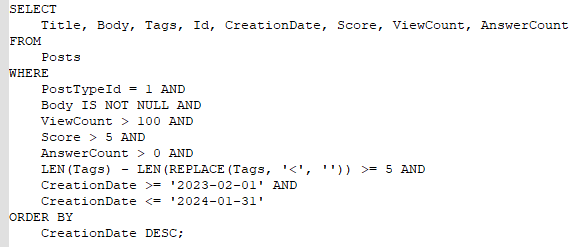

In [3]:
df_questions = pd.read_csv("QueryResults-1an.csv")
df_questions.head(5)

,Title,Body,Tags,Id,CreationDate,Score,ViewCount,AnswerCount
0,Combined with C++23 Deducing this and conversi...,<p>I recently noticed a strange issue regardin...,<c++><language-lawyer><type-deduction><c++23><...,77894686,2024-01-28 11:55:59,14,853,1
1,Overload resolution and template argument dedu...,"<p>In the following example, <code>0</code> be...",<c++><templates><overload-resolution><template...,77879331,2024-01-25 10:48:55,26,1375,1
2,Godot java.lang.IllegalStateException: Service...,<p>I'm published a game made with Godot 3.5.2<...,<java><android><mobile><game-engine><godot>,77871397,2024-01-24 08:08:18,8,1097,1
3,I am using react-fast-marquee for a horizontal...,"<p>I have the following code, and it is workin...",<javascript><css><reactjs><animation><scroll>,77856229,2024-01-21 18:57:24,6,139,2
4,std::type_identity to support several variadic...,<p><code>std::type_identity</code> can be used...,<c++><templates><language-lawyer><c++20><param...,77832658,2024-01-17 13:05:04,6,249,1


In [4]:
df_questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         640 non-null    object
 1   Body          640 non-null    object
 2   Tags          640 non-null    object
 3   Id            640 non-null    int64 
 4   CreationDate  640 non-null    object
 5   Score         640 non-null    int64 
 6   ViewCount     640 non-null    int64 
 7   AnswerCount   640 non-null    int64 
dtypes: int64(4), object(4)
memory usage: 40.1+ KB


In [5]:
df_maintenance = df_questions.copy()
df_maintenance['CreationDate'] = pd.to_datetime(df_maintenance['CreationDate'])
df_maintenance = df_maintenance.loc[df_maintenance['CreationDate'] >= '2023-02-01']
df_maintenance.head()

,Title,Body,Tags,Id,CreationDate,Score,ViewCount,AnswerCount
0,Combined with C++23 Deducing this and conversi...,<p>I recently noticed a strange issue regardin...,<c++><language-lawyer><type-deduction><c++23><...,77894686,2024-01-28 11:55:59,14,853,1
1,Overload resolution and template argument dedu...,"<p>In the following example, <code>0</code> be...",<c++><templates><overload-resolution><template...,77879331,2024-01-25 10:48:55,26,1375,1
2,Godot java.lang.IllegalStateException: Service...,<p>I'm published a game made with Godot 3.5.2<...,<java><android><mobile><game-engine><godot>,77871397,2024-01-24 08:08:18,8,1097,1
3,I am using react-fast-marquee for a horizontal...,"<p>I have the following code, and it is workin...",<javascript><css><reactjs><animation><scroll>,77856229,2024-01-21 18:57:24,6,139,2
4,std::type_identity to support several variadic...,<p><code>std::type_identity</code> can be used...,<c++><templates><language-lawyer><c++20><param...,77832658,2024-01-17 13:05:04,6,249,1


In [6]:
df_maintenance.info()

<class 'pandas.core.frame.DataFrame'>
Index: 640 entries, 0 to 639
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Title         640 non-null    object        
 1   Body          640 non-null    object        
 2   Tags          640 non-null    object        
 3   Id            640 non-null    int64         
 4   CreationDate  640 non-null    datetime64[ns]
 5   Score         640 non-null    int64         
 6   ViewCount     640 non-null    int64         
 7   AnswerCount   640 non-null    int64         
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 45.0+ KB


## Chargement des fichiers pickle

In [7]:
# Chargement du modèle
with open('final_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Chargement des listes pour la fonction process_text
with open('lists_data.pkl', 'rb') as fichier:
    lists_data_loaded = pickle.load(fichier)

technical_terms = lists_data_loaded['technical_terms']
words_to_remove = lists_data_loaded['words_to_remove']
eng_words = lists_data_loaded['eng_words']
list_top_tags = lists_data_loaded['list_top_tags']

# Chargement du multilabel binarizer
with open('multilabel_binarizer.pkl', 'rb') as fichier:
    multilabel_binarizer = pickle.load(fichier)

In [8]:
# Chargement du modèle USE
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

## Nettoyage des données

In [9]:
# Concatener les titres et les questions
df_maintenance['Title_Body'] = df_maintenance['Title'].astype(str) + ' ' + df_maintenance['Body'].astype(str)

# Enlever les balises HTML et supprimer les morceaux de codes des questions
for idx, ser in df_maintenance.iterrows():
    corpus_clean = clean_text(ser['Title_Body'])
    df_maintenance.at[idx, 'Title_Body'] = corpus_clean

In [10]:
# Pour les questions
df_maintenance['clean_title_body'] = df_maintenance['Title_Body'].mapply(process_text, 
                                                                     rejoin = False, 
                                                                     lemm_or_stemm ='lem', 
                                                                     words_to_remove = words_to_remove, 
                                                                     technical_terms = technical_terms, 
                                                                     min_len_word = 2, 
                                                                     force_is_alpha = True, 
                                                                     eng_words = eng_words)

C:\Users\Basti\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/6 [00:00<?, ?it/s]

In [11]:
# Pour les tags
df_maintenance['clean_tags'] = df_maintenance['Tags'].mapply(process_text, 
                                                         rejoin = False, 
                                                         lemm_or_stemm ='lem', 
                                                         words_to_remove = None, 
                                                         technical_terms = technical_terms, 
                                                         min_len_word = 2, 
                                                         force_is_alpha = True, 
                                                         eng_words = list_top_tags)

C:\Users\Basti\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


  0%|          | 0/6 [00:00<?, ?it/s]

In [12]:
# Supprimer les doublons de la colonne 'clean_tags'
df_maintenance['clean_tags'] = df_maintenance['clean_tags'].apply(lambda x: list(set(x)))

# Appliquer une fonction lambda pour ne conserver que les deux premiers tags
df_maintenance['clean_tags'] = df_maintenance['clean_tags'].apply(lambda x: x[:2] if isinstance(x, list) else x)

## Analyse de la stabilité du modèle dans le temps (simulation 1 an)

Chargement de USE (Universal Sentence Encoding) :

In [13]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

Mise en place d'une expérience MLFlow :

In [14]:
# Définir le chemin du répertoire de suivi
mlflow.set_tracking_uri("file:///" + os.path.expanduser('~/mlruns'))

# Identification du nom du projet MLflow
mlflow.set_experiment("Model_stability")

<Experiment: artifact_location='file:///C:\\Users\\Basti/mlruns/528030015125519018', creation_time=1708531303078, experiment_id='528030015125519018', last_update_time=1708531303078, lifecycle_stage='active', name='Model_stability', tags={}>

In [15]:
from pyngrok import ngrok
# Terminate open tunels if exist
ngrok.kill()

# Setting the authtoken
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = '2b23hnwzT4i2IwyrnERQYBHW6oM_5KfLu5ne9aeQKmtUtyZLK'
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
# Utiliser la commande shell mlflow ui pour l'activer
ngrok_tunel = ngrok.connect(addr='5000', proto='http', bind_tls=True)
print('MLflow Tracking UI:', ngrok_tunel.public_url)

MLflow Tracking UI: https://37ec-2a01-e0a-b69-82d0-2491-24f4-c69b-2f6f.ngrok-free.app


Exécuter 'mlflow ui' dans un terminal et cliquer ensuite sur le lien ci-dessus.

Enregistrement des résultats mensuels :

In [16]:
# Définition des dates de début et de fin
start_date = df_maintenance['CreationDate'].min()
end_date = df_maintenance['CreationDate'].max()

# Générer les dates mensuelles
D = pd.date_range(start=start_date, end=end_date, freq='MS')

# Boucle sur les dates mensuelles
for i, date in enumerate(D, start=1):
    # Sélectionner le mois correspondant
    df_month = df_maintenance[(df_maintenance['CreationDate'] >= date)\
                              & (df_maintenance['CreationDate'] < date + pd.DateOffset(months=1))]
    
    # Création de la matrice d'embedding pour réentrainer le modèle
    sentences = df_month['clean_title_body']
    batch_size = 1
    X = feature_USE_fct(sentences, batch_size)

    # Ecodage des labels
    y = df_month['clean_tags']
    y = multilabel_binarizer.transform(y)
    
    # Enregistrement de la run du modèle dans MLFlow
    run_name = f'Mois_{i}'
    name = f'Mois_{i}'
    name = mlflow_run(run_name, loaded_model, X, y, 'log_reg')
    mlflow.end_run()
    
    # Affichage des scores et du pourcentage de prédiction du modèle
    score(df_results, run_name, name['jaccard_index'], name['f1'], name['pred'])
    
# Affichage des scores
df_results

C:\Users\Basti\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


,Mois,F1_score,Jaccard_score,Taux de prédiction
0,Mois_1,0.698925,0.537190,79.761905
1,Mois_2,0.559585,0.388489,65.591398
2,Mois_3,0.606061,0.434783,78.205128
3,Mois_4,0.565517,0.394231,73.239437
4,Mois_5,0.652482,0.484211,79.687500
5,Mois_6,0.614173,0.443182,74.603175
6,Mois_7,0.642857,0.473684,83.333333
7,Mois_8,0.552632,0.381818,82.926829
8,Mois_9,0.515152,0.346939,74.285714
9,Mois_10,0.631579,0.461538,80.000000


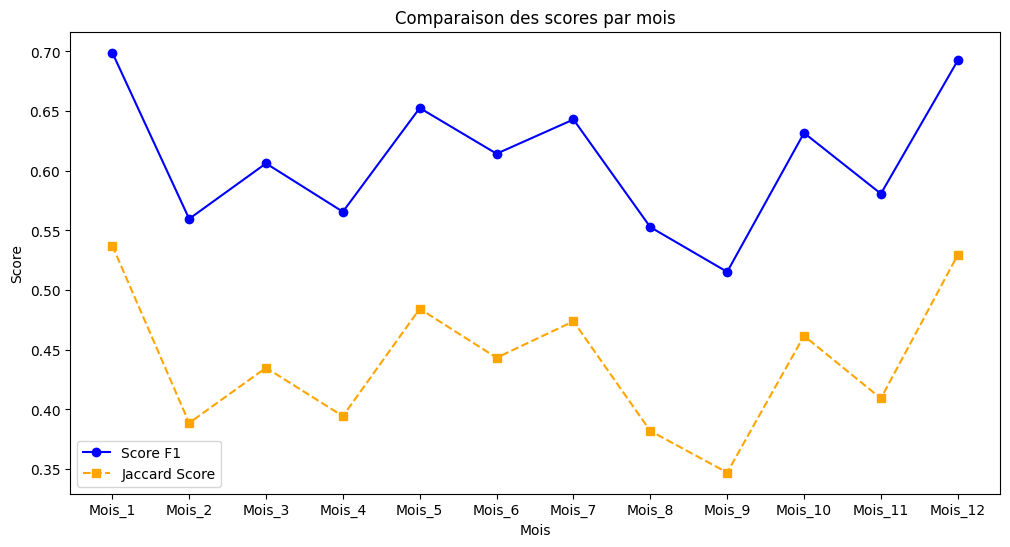

In [17]:
# Créer une liste d'indices pour chaque modèle
model_indices = np.arange(len(df_results['Mois']))

# Créer une figure et un axe pour les graphiques
fig, ax = plt.subplots(figsize=(12, 6))

# Tracer les lignes
ax.plot(model_indices, df_results['F1_score'], marker='o', linestyle='-', color='blue', label='Score F1')
ax.plot(model_indices, df_results['Jaccard_score'], marker='s', linestyle='--', color='orange', label='Jaccard Score')

# Ajouter des étiquettes et une légende
ax.set_xlabel('Mois')
ax.set_ylabel('Score')
ax.set_title('Comparaison des scores par mois')
ax.set_xticks(model_indices)
ax.set_xticklabels(df_results['Mois'])
ax.legend()

plt.show()

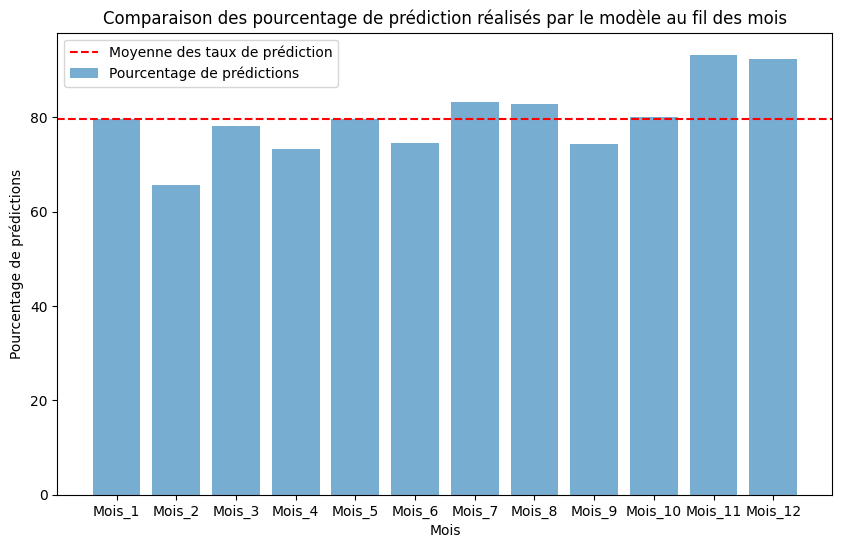

In [18]:
# Créer une figure et un axe pour les graphiques
fig, ax = plt.subplots(figsize=(10, 6))

# Tracer le temps d'exécution pour chaque modèle
ax.bar(df_results['Mois'], df_results["Taux de prédiction"], label='Pourcentage de prédictions', alpha=0.6)

# Tracer la moyenne du taux de prédiction du modèle sur 12 mois
mean_prediction_rate = df_results["Taux de prédiction"].mean()
ax.axhline(mean_prediction_rate, color='red', linestyle='--', label='Moyenne des taux de prédiction')

# Ajouter des étiquettes et une légende
ax.set_xlabel('Mois')
ax.set_ylabel("Pourcentage de prédictions")
ax.set_title("Comparaison des pourcentage de prédiction réalisés par le modèle au fil des mois")
ax.legend()
plt.show()